# 🎓 Maestría en Inteligencia Artificial Aplicada

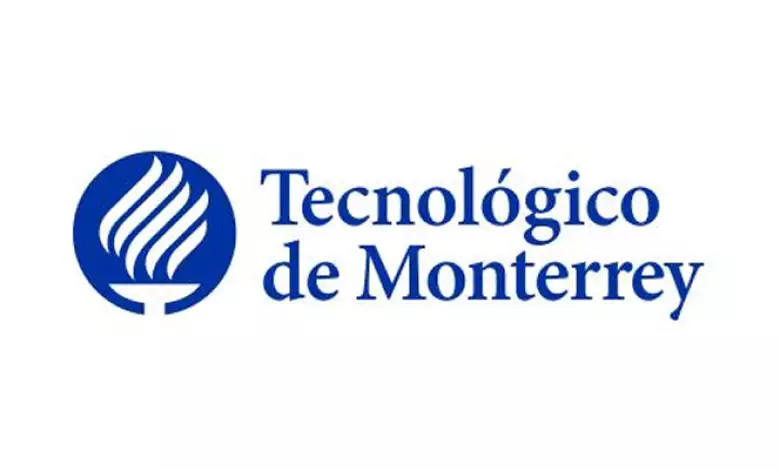

## 🖼️ **Proyecto Integrador**

### 👨‍🏫 **Profesores**

- **Profesor Titular:** Dra. Grettel Barceló Alonso
- **Asesor:** Dr. Horacio Martínez Alfaro

## **<font color="#895cf9">Avance 1. Análisis exploratorio de datos</font>**
### **Spin Compass**

### 📌 **Detalles de la Actividad**

- **Código:** 10.5 Google Colab
- **Título:** Avance 1. Análisis exploratorio de datos
- **Fecha de entrega:** Febrero 1 , 2026 a las 23:59
- **Formato de entrega:** Notebook (.ipynb) + Informe
- **Modalidad:** Equipo

## 👥 **Equipo 5**

### 🚀 **Nuestro Equipo**

  - Tania Alicia Caballero Saavedra - A01795957
  - Oscar Enrique García García - A01016093
  - Dante Rosas Fragoso – A01795850



---
# 1. 🔧 Configuración e Instalación <a id="setup"></a>

Importamos las librerías necesarias y definimos las rutas a utilizar dentro del código

In [1]:
import os
import re
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# NLP
import tiktoken

# Visual
plt.rcParams["figure.figsize"] = (8, 4)

# Paths
PROJECT_ROOT = Path("..")
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"


In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/Colab_Notebooks/MNA/Proyecto_Integrador-main")
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"

assert PROJECT_ROOT.exists(), "No se encontró el proyecto"
assert RAW_DATA_PATH.exists(), "No se encontró data/raw"

print("Project root:", PROJECT_ROOT)
print("Raw data path:", RAW_DATA_PATH)


Project root: /content/drive/MyDrive/Colab_Notebooks/MNA/Proyecto_Integrador-main
Raw data path: /content/drive/MyDrive/Colab_Notebooks/MNA/Proyecto_Integrador-main/data/raw


# 2. 📥 Carga de documentos <a id="download"></a>

Se instalan librerías adicionales y se definen funciones que funcionarán para la carga, extracción y procesamiento de texto, así como de imrpesión de estadísticas generales.

In [4]:
!pip install pymupdf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 82.3 MB/s eta 0:00:00


In [5]:
import fitz  # PyMuPDF


In [6]:
#Funcion para extraer pdfs
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text


In [7]:
def load_documents(base_path):
    docs = []
    for path in base_path.rglob("*"):
        if path.suffix.lower() == ".pdf":
            text = extract_text_from_pdf(str(path))
        elif path.suffix.lower() in [".txt", ".md"]:
            text = path.read_text(encoding="utf-8", errors="ignore")
        else:
            continue

        docs.append({
            "file": path.name,
            "path": str(path),
            "text": text
        })
    return pd.DataFrame(docs)

df_docs = load_documents(RAW_DATA_PATH)
df_docs.shape


(4, 3)

In [8]:
#Detectamos que este cargando bien los PDFs
print(df_docs["text"].iloc[0][:500])


 
Spin 
HOJA 
1 de 10 
Código  
ND-TIFS-PEC-001 
Dirección Administración y Finanzas  
Versión: 
1.0 
Política de Equipos de Cómputo 
Fecha de creación: 
31/10/2024 
 
Fecha de modificación 
31/10/2024 
 
Estatus 
Vigente 
 
 
La información contenida en este documento es INTERNA, para uso exclusivo del personal de Spin. 
Ninguna de sus partes puede ser circulada, citada o reproducida para distribución fuera de Spin sin 
autorización previa y por escrito. 
Interna 
Dirección Administración y Fin


In [9]:
import re

def split_into_sentences(text):
    # divide por punto, signo de interrogación o exclamación
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return [s for s in sentences if len(s.strip()) > 20]


In [10]:
def reconstruct_paragraphs(text, sentences_per_paragraph=5):
    sentences = split_into_sentences(text)
    paragraphs = [
        " ".join(sentences[i:i+sentences_per_paragraph])
        for i in range(0, len(sentences), sentences_per_paragraph)
    ]
    return paragraphs


In [11]:
def basic_stats(text):
    paragraphs = reconstruct_paragraphs(text)
    return {
        "chars": len(text),
        "words": len(text.split()),
        "paragraphs": len(paragraphs)
    }



stats = df_docs["text"].apply(basic_stats).apply(pd.Series)
df = pd.concat([df_docs.drop(columns="text"), stats], axis=1)
df.describe()


,chars,words,paragraphs
count,4.000000,4.000000,4.000000
mean,35277.500000,5025.000000,32.750000
std,14956.994206,1976.109815,14.150972
min,21314.000000,3192.000000,23.000000
25%,23214.500000,3456.000000,23.000000
50%,34211.000000,4823.500000,27.500000
75%,46274.000000,6392.500000,37.250000
max,51374.000000,7261.000000,53.000000


Tras incorporar una etapa de extracción correcta de texto desde PDF, se observó una reducción significativa en el tamaño aparente de los documentos. En promedio, los archivos contienen alrededor de 5,000 palabras y 1,000 líneas, lo cual confirma que el análisis previo estaba afectado por la lectura directa del contenido binario del PDF.

Esta corrección permitió realizar un análisis exploratorio válido sobre texto legible por máquina.

# 3. 🎧 Reducción de ruido <a id="noise"></a>

A continuación se define una clase NoiseReducer que nos ayudará a normalizar el texto de los diferentes documentos a procesar, a partir de expresiones regulares y algunas otras transformaciones.

In [12]:
class NoiseReducer:
    def __init__(self):
        self.patterns = [
            r"page\s+\d+(\s+of\s+\d+)?",
            r"página\s+\d+(\s+de\s+\d+)?",
            r"instituto tecnológico.*",
            r"tecnológico de monterrey.*",
            r"este documento.*confidencial.*",
        ]

    def clean(self, text):
        text = text.lower()

        # eliminar ruido repetitivo
        for p in self.patterns:
            text = re.sub(p, "", text, flags=re.IGNORECASE)

        # 🔑 NORMALIZACIÓN CORRECTA DE SALTOS
        text = re.sub(r"\n{3,}", "\n\n", text)   # colapsa excesivos
        text = re.sub(r"\n\s*\n", "\n\n", text) # normaliza párrafos

        return text.strip()


In [13]:
noise_reducer = NoiseReducer()
df_docs["clean_text"] = df_docs["text"].apply(noise_reducer.clean)


In [14]:
df_docs["clean_text"] = df_docs["text"].apply(noise_reducer.clean)

before = df_docs["text"].apply(basic_stats).apply(pd.Series)
after = df_docs["clean_text"].apply(basic_stats).apply(pd.Series)

comparison = pd.concat(
    [before.add_prefix("before_"), after.add_prefix("after_")],
    axis=1
)

comparison.describe()


,before_chars,before_words,before_paragraphs,after_chars,after_words,after_paragraphs
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,35277.500000,5025.000000,32.750000,34881.500000,5025.000000,32.750000
std,14956.994206,1976.109815,14.150972,14861.536944,1976.109815,14.150972
min,21314.000000,3192.000000,23.000000,21037.000000,3192.000000,23.000000
25%,23214.500000,3456.000000,23.000000,22915.000000,3456.000000,23.000000
50%,34211.000000,4823.500000,27.500000,33733.500000,4823.500000,27.500000
75%,46274.000000,6392.500000,37.250000,45700.000000,6392.500000,37.250000
max,51374.000000,7261.000000,53.000000,51022.000000,7261.000000,53.000000


In [15]:
!pip install tiktoken

In [16]:
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")

df_docs["tokens"] = df_docs["clean_text"].apply(
    lambda x: len(encoding.encode(x))
)

df_docs["tokens"].describe()


,tokens
count,4.000000
mean,9302.000000
std,3842.283956
min,5752.000000
25%,6179.500000
50%,9013.500000
75%,12136.000000
max,13429.000000


In [17]:
def count_paragraphs(text):
    return len(reconstruct_paragraphs(text))

df_docs["paragraphs"] = df_docs["clean_text"].apply(count_paragraphs)

df_docs["tokens_per_paragraph"] = (
    df_docs["tokens"] / df_docs["paragraphs"]
)

df_docs[["tokens", "paragraphs", "tokens_per_paragraph"]].describe()


,tokens,paragraphs,tokens_per_paragraph
count,4.000000,4.000000,4.000000
mean,9302.000000,32.750000,286.028783
std,3842.283956,14.150972,54.292156
min,5752.000000,23.000000,250.086957
25%,6179.500000,23.000000,252.554758
50%,9013.500000,27.500000,264.123462
75%,12136.000000,37.250000,297.597486
max,13429.000000,53.000000,365.781250


In [18]:
import re

def normalize_text(text):
    #Colapsamos multiples saltos de linea y revisamos cuales son parrafos
    text = re.sub(r"\n{2,}", "\n\n", text)
    # Reemplazamos saltos de línea simples por espacios
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    return text

df_docs["clean_text"] = df_docs["text"].apply(normalize_text)


📈 Resultados:

Dado que los documentos PDF no preservan explícitamente la estructura de párrafos, se aplicó una reconstrucción heurística basada en la agrupación de oraciones. Esta aproximación permite analizar la densidad semántica y fundamentar la estrategia de segmentación utilizada en el sistema RAG.*italicized text*

# 4. 📖 Conteo de encabezados <a id="headers"></a>

A continuación se define una función que, a partir de expresiones regulares, es capaz de extraer los títulos de cada sección en los documentos. Esto nos ayudará a determinar de mejor forma los chunkings en cada uno de ellos.

In [19]:
#Contaremos las secciones
HEADER_PATTERNS = [
    r"^\d+\.\s+.+",            # 1. Título
    r"^\d+\.\d+\s+.+",         # 1.1 Subtítulo
    r"^[A-ZÁÉÍÓÚÑ ]{5,}$",     # TÍTULOS EN MAYÚSCULAS
    r"^cap[ií]tulo\s+\d+",     # Capítulo 1
    r"^secci[oó]n\s+\d+",      # Sección 2
]


In [20]:
import re

def count_headers(text):
    # dividir en "líneas lógicas"
    lines = re.split(r"[.\n]\s+", text)

    header_count = 0
    for line in lines:
        line = line.strip()
        for pattern in HEADER_PATTERNS:
            if re.match(pattern, line):
                header_count += 1
                break
    return header_count
df_docs["headers"] = df_docs["clean_text"].apply(count_headers)

df_docs[["file", "headers"]]


,file,headers
0,politica-equipos-computo.pdf,10
1,politica-telefonia.pdf,9
2,politica-abastecimiento.pdf,7
3,politica-gastos-viajes.pdf,19


Resultados:

Todos los documentos tienen estructura interna y no son “texto plano largo”, lo cual nos define que hay secciones claramente diferenciadas y que son  documentos altamente estructurados.

Esto quiere decir que:

❌ Chunking por tokes no es optimo, ya que corta el contexto sin entender significado y si varios documentos tienen palabras similares podria confundirse a la hora de recuperar el documento.

✅ Por ello, usaremos el chunking semantico, el cual intenta no romper unidades de significado y, como vemos que se tienen secciones claras, el chunking semántico puede mantener la continuidad del documento.

Más adelante haremos una comprobación y análisis detallado del chunking lineal vs el chunking semántico.

# 5. 🈵 Detección de idioma <a id="language"></a>

In [21]:
!pip install langid



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=7e34cbd205af8508980ef35454a550bc96d38efe1cd1a2b35e196d1806f43360
  Stored in directory: /root/.cache/pip/wheels/3c/bc/9d/266e27289b9019680d65d9b608c37bff1eff565b001c977ec5
Successfully built langid


In [22]:
import langid
langid.set_languages(["es", "en"])

def detect_lang(text):
    sample = text[:2000]
    lang, confidence = langid.classify(sample)
    return lang, confidence

df_docs[["lang_detected", "lang_confidence"]] = (
    df_docs["clean_text"]
    .apply(lambda x: pd.Series(detect_lang(x)))
)

df_docs[["file", "lang_detected", "lang_confidence"]]


,file,lang_detected,lang_confidence
0,politica-equipos-computo.pdf,es,-5987.816097
1,politica-telefonia.pdf,es,-6668.315648
2,politica-abastecimiento.pdf,es,-5434.413899
3,politica-gastos-viajes.pdf,es,-5624.590316


La tabla anterior nos muestra que no hay mezlca de idiomas en ninguno de los documentos y que todos ellos están en español. Esto nos ayudará a elegir el embedding más adecuado (e.g. no es necesario por ahora un modelo multilingüe, aunque más adelante puede servirnos si se incorpora algún documento en otro idioma).

# 6. 🧱 Chunking semántico vs líneal <a id="chunking"></a>

Por último, esta gráfica nos permite analizar cuántos chunks debemos hacer y a qué costo saldria :

**300 tokens:**
Hablamos de muchos chunks, más de 1250 ( hasta 1800 en el documento 2)
Esto quiere decir que tendríamos un proceso mas lento y costoso.


**500 Tokens**
Vemos una reducción fuerte ( casi la mitad en promedio) de 1800 a 800 en el documento 2.
Parece que aún hay buena granularidad

**800 tokens**
Tenemos una reducción significativa del de 300; sin embargo, corremos el riesgo de que el contexto sea muy grande y los chunks sean difusos y error a la hora de recuperarlos.

En conclusión, se sugiere usar 500 tokens como el balance óptimo entre  granularidad y eficiencia computacional, esto es respladado en el paso 2 donde se hizo un análisis de chunks  (300,500 y 800)




## 6.1 🧱 Chunking lineal <a id="linear"></a>

In [23]:
def chunking_lineal(text, chunk_size=500, overlap=100):
    tokens = encoding.encode(text)
    chunks = []
    start = 0

    while start < len(tokens):
        end = start + chunk_size
        chunk = encoding.decode(tokens[start:end])
        chunks.append(chunk)
        start += chunk_size - overlap

    return chunks


In [24]:
linear_chunks = chunking_lineal(df_docs["clean_text"].iloc[0])
len(linear_chunks)


15

## 6.2 🧱 Chunking semántico <a id="semantic"></a>

Como previamente ya detectamos encabezados y vimos que cada documento está bien dividido por secciones y puntos a destacar, haremos el semantic chunking a través de estos encabezados.

In [25]:
def split_by_headers(text):
    sections = []
    current = []

    for line in text.split(". "):
        if line.strip().isupper() or line.strip().startswith(tuple("0123456789")):
            if current:
                sections.append(" ".join(current))
                current = []
        current.append(line)

    if current:
        sections.append(" ".join(current))

    return sections


In [26]:
sections = split_by_headers(df_docs["clean_text"].iloc[0])
len(sections)


41

In [27]:
def semantic_chunking_sentence_based(text, max_tokens=500):
    sections = split_by_headers(text)
    chunks = []

    for section in sections:
        sentences = split_into_sentences(section)
        current = ""

        for sent in sentences:
            candidate = (current + " " + sent).strip()

            if len(encoding.encode(candidate)) <= max_tokens:
                current = candidate
            else:
                if current.strip():            # 🔑 evita chunks vacíos
                    chunks.append(current.strip())
                current = sent

        if current.strip():                    # 🔑 último chunk
            chunks.append(current.strip())

    return chunks


In [28]:
semantic_chunks = semantic_chunking_sentence_based(
    df_docs["clean_text"].iloc[0],
    max_tokens=500
)


## 6.3 🧱 Comparación entre tipos de chunking <a id="comparison"></a>

In [29]:
# Chunking lineal (baseline)
linear_chunks = chunking_lineal(
    df_docs["clean_text"].iloc[0],
    chunk_size=500,
    overlap=100
)

# Chunking semántico (mejorado, por oraciones)
semantic_chunks = semantic_chunking_sentence_based(
    df_docs["clean_text"].iloc[0],
    max_tokens=500
)


In [30]:
#Comparacion entre numero de chunks lineales vs chunks semanticos
print("Linear chunks:", len(linear_chunks))
print("Semantic chunks:", len(semantic_chunks))


Linear chunks: 15
Semantic chunks: 36


In [31]:
for i in range(3):
    print("\n==============================")
    print(f"CHUNK {i+1}")
    print("------ LINEAL ------")
    print(linear_chunks[i][:400])
    print("\n---- SEMÁNTICO ----")
    print(semantic_chunks[i][:400])



CHUNK 1
------ LINEAL ------
  Spin  HOJA  1 de 10  Código   ND-TIFS-PEC-001  Dirección Administración y Finanzas   Versión:  1.0  Política de Equipos de Cómputo  Fecha de creación:  31/10/2024    Fecha de modificación  31/10/2024    Estatus  Vigente      La información contenida en este documento es INTERNA, para uso exclusivo del personal de Spin.  Ninguna de sus partes puede ser circulada, citada o reproducida para distrib

---- SEMÁNTICO ----
Spin  HOJA  1 de 10  Código   ND-TIFS-PEC-001  Dirección Administración y Finanzas   Versión:  1.0  Política de Equipos de Cómputo  Fecha de creación:  31/10/2024    Fecha de modificación  31/10/2024    Estatus  Vigente      La información contenida en este documento es INTERNA, para uso exclusivo del personal de Spin  Ninguna de sus partes puede ser circulada, citada o reproducida para distribuci

CHUNK 2
------ LINEAL ------
  Código   ND-TIFS-PEC-001  Dirección Administración y Finanzas   Versión:  1.0  Política de Equipos de Cómputo  Fech

In [32]:
import pandas as pd

examples = pd.DataFrame({
    "linear_chunk": linear_chunks[:5],
    "semantic_chunk": semantic_chunks[:5]
})

examples


,linear_chunk,semantic_chunk
0,Spin HOJA 1 de 10 Código ND-TIFS-PEC-00...,Spin HOJA 1 de 10 Código ND-TIFS-PEC-001 ...
1,Código ND-TIFS-PEC-001 Dirección Administ...,NORMAS GENERALES 5.1 ASIGNACIÓN 5.2 RENOVACI...
2,"ada, citada o reproducida para distribución fu...","NEGLIGENCIA, DAÑOS, FALLAS, ROBO O EXTRAVÍO 8"
3,es ilustrativa y se toma como base de referen...,VENTA DE EQUIPOS 8.1 VENTA DE EQUIPOS A COLAB...
4,para realizar cambio de equipo. 5.1.6 El á...,2 OBJETIVO Establecer los lineamientos para l...


Resultados:

La comparación cualitativa muestra que el chunking lineal genera fragmentos que mezclan metadata, introducción y reglas normativas, mientras que el chunking semántico preserva la integridad de las secciones del documento. Aunque el primer fragmento semántico agrupa contenido introductorio extenso, los fragmentos subsecuentes corresponden claramente a secciones específicas como objetivos y alcance, lo que facilita una recuperación más precisa y contextualizada.

Si bien se podria mejorar aun mas el chunking haciendo acumulacion de oraciones para comparar contra el embedding del chunk completo... eso lo dejaremos para futuras entregas, lo que si se puede observar es que el chunking semantico es la mejor opcion.

In [35]:
# Tamaño de chunks en tokens
linear_sizes = [len(encoding.encode(c)) for c in linear_chunks]
semantic_sizes = [len(encoding.encode(c)) for c in semantic_chunks]
#Importamos data frames
df_box = pd.DataFrame({
    "tokens": linear_sizes + semantic_sizes,
    "estrategia": (
        ["Chunking lineal"] * len(linear_sizes)
        + ["Chunking semántico"] * len(semantic_sizes)
    )
})


<Figure size 600x500 with 0 Axes>

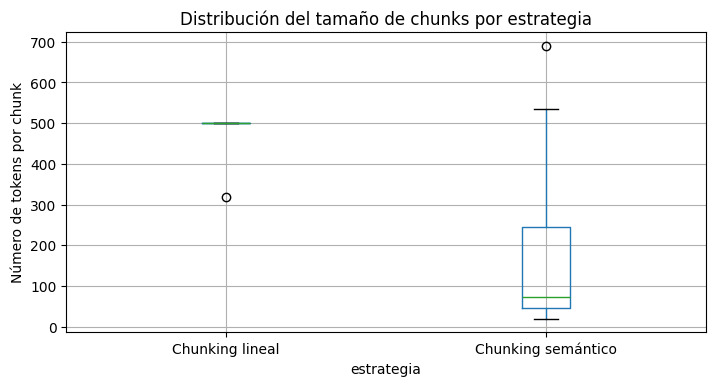

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
df_box.boxplot(by="estrategia", column="tokens")
plt.suptitle("")  # quita título automático
plt.title("Distribución del tamaño de chunks por estrategia")
plt.ylabel("Número de tokens por chunk")
plt.show()


Resultados:

El box plot evidencia diferencias claras entre las estrategias de segmentación. El chunking lineal produce fragmentos de tamaño casi uniforme, con una mediana cercana al límite de tokens establecido y baja variabilidad. En contraste, el chunking semántico presenta una distribución más dispersa, con fragmentos de tamaño variable que reflejan la longitud natural de las secciones del documento. Esta variabilidad indica que el chunking semántico se adapta al contenido, priorizando la coherencia semántica sobre la uniformidad en el tamaño de los fragmentos

# 7. 📔 Conclusión final del equipo <a id="conclusion"></a>

El análisis exploratorio de datos se centró en preparar un corpus de documentos normativos institucionales para su uso en un sistema de Recuperación Aumentada por Generación (RAG). En una primera etapa, se corrigió el proceso de extracción de texto desde archivos PDF, asegurando que el análisis se realizara sobre contenido legible por máquina y no sobre artefactos binarios. Posteriormente, se aplicaron técnicas de reducción de ruido para eliminar encabezados, pies de página, numeración y texto repetitivo, logrando una limpieza conservadora que redujo contenido irrelevante sin afectar la información semántica ni la estructura lógica de los documentos.

El análisis reveló que los documentos presentan una estructura jerárquica clara, caracterizada por la presencia de múltiples encabezados y secciones bien definidas. Dado que la estructura de párrafos no se conserva explícitamente en los archivos PDF, se implementó una reconstrucción heurística basada en oraciones, lo que permitió recuperar unidades lógicas de contenido para su análisis. Las métricas de tokens y densidad semántica confirmaron que los documentos son lo suficientemente extensos como para requerir segmentación, y que una división puramente basada en longitud podría fragmentar reglas, condiciones y excepciones relevantes.

La comparación entre estrategias de segmentación mostró diferencias significativas. El chunking lineal, basado únicamente en el tamaño del texto, produjo fragmentos uniformes pero con cortes arbitrarios que mezclan secciones distintas o separan reglas de su contexto. En contraste, el chunking semántico guiado por encabezados y agrupación de oraciones preservó unidades de significado coherentes, alineando los fragmentos con la estructura normativa de los documentos. La inspección cualitativa de ejemplos confirmó que esta estrategia ofrece mayor coherencia contextual y resulta más adecuada para tareas de recuperación de información.

En conjunto, los resultados del EDA justifican la selección de una estrategia de chunking semántico jerárquico como base para el sistema RAG. Tras la limpieza, reconstrucción estructural y segmentación del corpus, los documentos se encuentran en un estado adecuado para la generación de embeddings y su posterior indexación en una base vectorial, reduciendo el riesgo de pérdida de contexto y mejorando la precisión del proceso de recuperación.